In [1]:
from __future__ import division
import sys
sys.path.insert(0, '/home/gw2397/cluster_new')
sys.path.insert(0, '/home/gw2397/pyhsmm-autoregressive-master')
sys.path.insert(0, '/home/gw2397/nbRegg_mcmc')

import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import *
from scipy.interpolate import *
from cluster_functions import *
import scipy

import pyhsmm
from pyhsmm.util.text import progprint_xrange
from pyhsmm.util.stats import whiten, cov

import autoregressive.models as m
import autoregressive.distributions as d

from polyagamma import random_polyagamma
import numpy as np
from pyhmc import hmc
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.special import gamma, digamma
from scipy.stats import norm, nbinom, multivariate_normal, poisson
from tqdm import tqdm
import heapq

import numpy.matlib
import time
from IPython import display

import warnings
import copy
warnings.filterwarnings("ignore")

/home/gw2397/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/gw2397/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/gw2397/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/gw2397/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
n = 10
nClus = 3
p = 2
T = 500

np.random.seed(0)
lab_neuron = np.repeat(np.arange(nClus), n)

dd = np.random.normal(size = (n*nClus,1))*0.5
C_true= np.random.normal(size = (nClus*n,p))*0.5+0.1

# sim 2
As = [block_diag(0.001*np.eye(p+1), 
                 0.001*np.eye(p+1), 
                 0.001*np.eye(p+1)),
      block_diag(1.01*random_rotation(p+1, theta= np.pi/20),
                 1.01*random_rotation(p+1, theta= np.pi/20),
                 1.01*random_rotation(p+1, theta= np.pi/20))]

truemodel = m.ARHSMM(
        alpha=5.,init_state_concentration=5.,
        obs_distns=[d.AutoRegression(A=A,sigma=np.eye(nClus*(p+1))*1e-2) for A in As],
        dur_distns=[pyhsmm.basic.distributions.PoissonDuration(alpha_0=100,beta_0=2)
            for state in range(len(As))],
        )


X_all_tmp, lab_t_tmp = truemodel.generate(2*T, keep=True)
X_all = X_all_tmp[501:,:].T
lab_t = lab_t_tmp[500:]

muX_all = []
for cc in range(nClus):
    muX_all.append(X_all[(cc*(p+1)):((cc+1)*(p+1)),:])
    
dynm = {}
dynm['As'] = np.zeros((2,3*(p+1),3*(p+1)))
dynm['bs'] = np.zeros((2,3*(p+1)))
dynm['Qs'] = np.zeros((2,3*(p+1),3*(p+1)))
dynm['states'] = np.zeros((T,), dtype = int)


# muX_b, C_b, delt_b.ravel(), dynamics_b

muX_all, C_true, _, _ = constraint(muX_all, C_true,dd.reshape((-1, 1)),dynm, lab_neuron)    
X_all = np.zeros_like(X_all)
for cc in range(nClus):
    X_all[(cc*(p+1)):((cc+1)*(p+1)),:] = muX_all[cc]

    
C_trans = np.zeros((n*nClus, (p+1)*nClus))
for cc in range(nClus):
    C_trans[(n*cc):(n*(cc+1)),(cc*(p+1)):((cc+1)*(p+1))] = np.column_stack((np.ones((n,1)), C_true[(n*cc):(n*(cc+1)),:]))    
    
# Lam_true = np.exp(dd + C_trans @ X_all)
# y =np.random.poisson(Lam_true)
Lam_true = np.exp(dd + C_trans @ X_all)
r_true = np.ones((n*nClus,1))*10
p_true = r_true/(r_true+Lam_true)
y = np.random.negative_binomial(r_true, p_true, size=None)

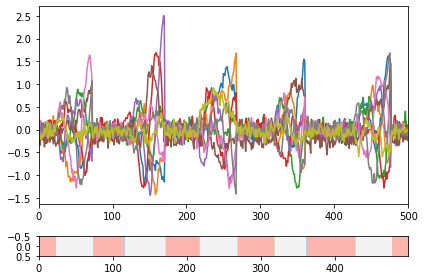

In [3]:
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [10, 1]})

a0.plot(X_all .T)
a0.set_xlim([0, T])
a1.imshow(lab_t[None,:], aspect="auto", cmap='Pastel1')

f.tight_layout()

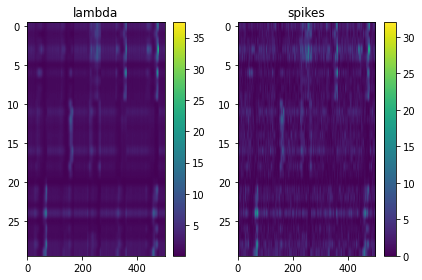

In [4]:
fig, ax = plt.subplots(1,2)

z1 = ax[0].imshow(Lam_true, aspect='auto')
ax[0].set_title('lambda')
plt.colorbar(z1, ax= ax[0])

z2 = ax[1].imshow(y, aspect='auto')
ax[1].set_title('spikes')
plt.colorbar(z2, ax= ax[1])

fig.tight_layout()

In [5]:
def poiLogMar(y_poi, X_poi, offset_poi):
    
    # OK, I just do Laplace approximation here...
    # to debug...
    # y_nb = Y_tmp[ii,:].ravel()
    # r_nb = r_tmp[ii]
    # X_nb = muX_b[cc][1:,:].T
    # offset_nb = muX_b[cc][0,:] + delta_tmp[ii,:]
    
    pois_res = sm.GLM(y_poi, X_poi, family=sm.families.Poisson(),
                      offset = offset_poi).fit()
    
    logMar = pois_res.llf + np.sum(norm.logpdf(pois_res.params)) + 0.5*np.log(np.linalg.det(pois_res.cov_params()))
    return logMar

In [13]:
def update_cluster_poi(Z_a, numClus_a, t_a, actList_a,
                       c_next_a,DPMM, alpha_random,
                       a, log_v, logNb, muX_a, delta_tmp,
                       Y_tmp, prior, alphaDP,sigma_alpha,t_max, dynamics_a, sample_tag):
    
    
    # to debug...
    # Z_a = Z_fit[gg-1,:].copy()
    # numClus_a = numClus_fit[gg-1,:].copy()
    # t_a = t_fit[gg-1].copy()
    # actList_a = actList_fit[gg-1,:].copy()
    # c_next_a = c_next
    # muX_a = muX_fit[gg].copy()
    # delta_tmp = delt_fit[gg,:].copy().reshape((-1, 1))
    # Y_tmp = y
    # dynamics_a = dynamics_fit[gg].copy()
    
    
    N = Y_tmp.shape[0]
    T = Y_tmp.shape[1]
    p = muX_a[0].shape[0]-1
    lAbsGam = lambda x: np.log(np.abs(gamma(x)))

    Z_b = copy.deepcopy(Z_a)
    numClus_b = copy.deepcopy(numClus_a)
    t_b = copy.deepcopy(t_a)
    actList_b = copy.deepcopy(actList_a)
    muX_b = copy.deepcopy(muX_a)
    c_next_b = c_next_a
    dynamics_b = copy.deepcopy(dynamics_a)
    
    if DPMM and alpha_random:
        # MH move for DP concentration parameter (using p_alpha(a) = exp(-a) = Exp(a|1))
        aprop = alphaDP*np.exp(np.random.uniform()*sigma_alpha)
        top = t_a*np.log(aprop) - lAbsGam(aprop+N) + lAbsGam(aprop) - aprop + np.log(aprop)
        bot = t_a*np.log(alphaDP) - lAbsGam(alphaDP+N) + lAbsGam(alphaDP) - alphaDP + np.log(alphaDP)
        if np.random.uniform() < min(1, np.exp(top-bot)):
            alphaDP = aprop
        log_v = np.arange(1, t_max+2)*np.log(alphaDP) - lAbsGam(alphaDP+N) + lAbsGam(alphaDP)
    
    for ii in range(N):
        
        # (a) remove point ii from its cluster
        c = Z_b[ii].copy()
        numClus_b[c] = numClus_b[c] - 1
        if numClus_b[c] > 0:
            c_prop = c_next_b
            if sample_tag == 1:
                muX_b[c_prop] = sample_muX(p, T)
            else:
                 muX_b[c_prop] = sample_muX2(p, T)
            # muX_b[c_prop] = jitters_muX(muX_b[c])
            
            ## for debugging...
            # muX_b[c_prop] = muX_all[0]
            
            
            ## to be safe...
            # while len(muX_b) <= c_prop:
            #     muX_b.append([])
            # muX_b[c_prop] = sample_muX(p, T)
            
        else:
            c_prop = c
            actList_b = ordered_remove(c, actList_b, t_b)
            t_b = t_b - 1
        
        # (b) compute probabilities for resampling
        log_p = np.zeros((t_b+1,))
        for j in range(t_b):
            cc = actList_b[j]
            # calculate the marginalized likelihood...
            try:
                
                logMar = poiLogMar(Y_tmp[ii,:].ravel(), muX_b[cc][1:,:].T,
                                   muX_b[cc][0,:] + delta_tmp[ii,:])
                
                
            except:
                logMar = -np.Inf
            
            log_p[j] = logNb[numClus_b[cc]-1] + logMar
        
        
        try:
            logMar = poiLogMar(Y_tmp[ii,:].ravel(), muX_b[c_prop][1:,:].T,
                               muX_b[c_prop][0,:] + delta_tmp[ii,:])
                
        except:
            logMar = -np.Inf
        log_p[t_b] = log_v[t_b] - log_v[t_b-1] + np.log(a) + logMar
        
        # (c) sample a new cluster for it
        j = randlogp(log_p, t_b+1)
    
        # (d) add point i to its new clusters
        if (j+1) <= t_b:
            c = actList_b[j]
        else:
            c = c_prop
            idx_tmp = np.arange(c*(p+1), (c+1)*(p+1))
            for ss in range(dynamics_b['As'].shape[0]):
                dynamics_b['bs'][ss,idx_tmp] = np.zeros((p+1,))
                dynamics_b['As'][ss,idx_tmp,:] = 0
                dynamics_b['As'][ss,:,idx_tmp] = 0
                dynamics_b['As'][ss,idx_tmp,idx_tmp] = 1
                dynamics_b['Qs'][ss,idx_tmp,:] = 0
                dynamics_b['Qs'][ss,:,idx_tmp] = 0
                dynamics_b['Qs'][ss,idx_tmp,idx_tmp] = 1e-2
            
            actList_b = ordered_insert(c, actList_b, t_b)
            t_b = t_b + 1
            c_next_b = ordered_next(actList_b)
        
        Z_b[ii] = c
        numClus_b[c] = numClus_b[c] + 1
    return Z_b, numClus_b, t_b, actList_b, c_next_b, muX_b, dynamics_b 

In [16]:
N = n*nClus
n_iter = 1000
t_max = int(N/2)
state_max = 5

## neuron-clustering realted
# DPMM:
# DPMM = True
# alpha_random = True
sigma_alpha = 0.1 # scale for MH proposals in alpha move
alphaDP = 1
# log_v = np.arange(1, t_max + 2)*np.log(alphaDP) - lAbsGam(alphaDP+N) + lAbsGam(alphaDP)
# a = 1
# b = 0

# MFM:
DPMM = False
alpha_random = False
MFMgamma = 1
# K ~ Geometric(r)
r = 0.2
log_pk = lambda k: np.log(r) + (k-1)*np.log(1-r)

a = MFMgamma
b = MFMgamma
log_v = MFMcoeff(log_pk, MFMgamma, N, t_max + 1)
logNb = np.log(np.arange(1,N+1) + b)

## state-clustering related
alpha_slds = 2.
gamma_slds = 4.
kappa_slds = 10

## other priors
prior = {}
prior['x0'] = np.zeros((p+1,1))
prior['Q0'] = np.eye(p+1)
prior['muC0'] = np.zeros((p,))
prior['SigC0'] = np.eye(p)
prior['mud0'] = 0
prior['s2d0'] = 1

prior['bA0'] = np.hstack((np.eye(p+1), np.zeros((p+1, 1))))
prior['Lam0'] = np.eye(p+1+1)
prior['Nu0'] = p+1+2
prior['Sig0'] = np.eye(p+1)*1e-2
a0 = 1
h = 1


## pre-allocation
t_fit = np.zeros((n_iter,), dtype = int)
Z_fit = np.zeros((n_iter, N), dtype = int)
numClus_fit = np.zeros((n_iter, t_max + 3), dtype = int)
actList_fit = np.ones((n_iter, t_max + 3), dtype = int)*-99 # different from MATLAB, cannot use 0 here

delt_fit = np.zeros((n_iter, N))
C_fit = np.zeros((n_iter, N, p))
muX_fit = [ [np.zeros((p+1, T)) for _ in range(t_max)] for _ in range(n_iter)]
dynamics_fit = []
for _ in range(n_iter):
    dynm = {}
    dynm['As'] = np.zeros((state_max,t_max*(p+1),t_max*(p+1)))
    dynm['bs'] = np.zeros((state_max,t_max*(p+1)))
    dynm['Qs'] = np.zeros((state_max,t_max*(p+1),t_max*(p+1)))
    dynm['states'] = np.zeros((T,), dtype = int)
    
    dynamics_fit.append(dynm)
    

## initialization

# start from 1 cluster
t_fit[0] = 1
Z_fit[0,:] = np.zeros((N,),dtype = int)
numClus_fit[0,0] = N
actList_fit[0,0] = 0
c_next = 1

delt_fit[0,:] = np.random.normal(prior['mud0'], prior['s2d0'], size = N)
C_fit[0,:] = np.random.multivariate_normal(prior['muC0'], prior['SigC0'], size = N)

for ii in range(n_iter):
    for qq in range(state_max):
        dynamics_fit[ii]['As'][qq,:,:] = np.eye(t_max*(p+1))
        dynamics_fit[ii]['Qs'][qq,:,:] = np.eye(t_max*(p+1))*1e-2

for jj in range(t_max):
    muX_fit[0][jj] = sample_muX(p,T)
    
muX_fit[0], C_fit[0,:], delt_fit[0,:], dynamics_fit[0] = constraint(muX_fit[0], C_fit[0,:,:],
                                                                    delt_fit[0,:].reshape((-1, 1)),
                                                                    dynamics_fit[0], Z_fit[0,:])

splitMerge_flag = False
splitL = 1
nSplit = 5
nMerge = 5

dynamics_sm = {}
dynamics_sm['As'] = np.zeros((state_max,p+1,p+1))
dynamics_sm['bs'] = np.zeros((state_max,p+1))
dynamics_sm['Qs'] = np.zeros((state_max,p+1,p+1))
dynamics_sm['states'] = np.zeros((T,), dtype = int)
dynamics_sm['As'][0,:,:] = np.eye(p+1)
dynamics_sm['Qs'][0,:,:] = np.eye(p+1)*1e-2

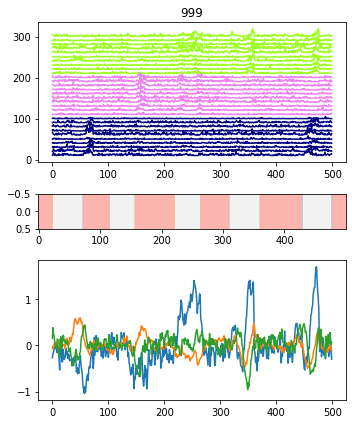

100%|██████████| 999/999 [27:14<00:00,  1.64s/it]


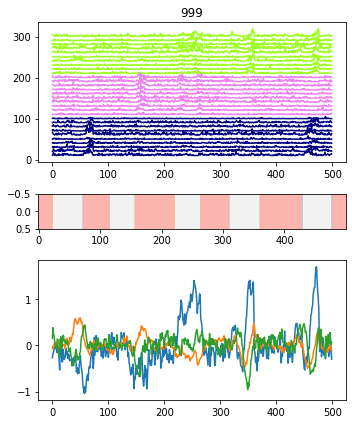

In [17]:
plt.rcParams['figure.figsize'] = [5, 6]

figure, (ax0, ax1, ax2) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [4, 1, 4]})
Yplot, z2, colors = clusterPlot_values(y,Z_fit[0,:])
line1 = ax0.plot(Yplot.T)
for mm in range(Yplot.shape[0]):
    line1[mm].set_color(colors[z2[mm]])
ax0.set_title(0)
ax1.imshow(dynamics_fit[0]['states'][None,:], aspect="auto", cmap='Pastel1')
ax2.plot(muX_fit[0][Z_fit[0,0]].T)
figure.tight_layout()

keep_flg = False
state_rep = 1
r_all = 100


for gg in tqdm(range(1,n_iter)):
    
    #### 0. store previous steps
    muX_tmp = muX_fit[gg-1].copy()
    delt_tmp = delt_fit[gg-1,:].reshape((-1, 1)).copy()
    C_tmp = C_fit[gg-1,:,:].copy()
    r_tmp = np.ones((N,1))*r_all
    dynamics_tmp = dynamics_fit[gg-1].copy()
    Z_tmp = Z_fit[gg-1,:].copy()

    #### 1. sample dynamical latents
    ## 1a. select corresponding muX & expand C to block diag
    lab_n_unique = sorted(set(Z_tmp))
    n_lab_n = len(lab_n_unique)
    lab_n_unique_dic = {}
    for kk in range(n_lab_n):
        lab_n_unique_dic[lab_n_unique[kk]] = kk

    muX_sel = np.zeros((n_lab_n*(p+1), T))

    As_sel = np.zeros((state_max,n_lab_n*(p+1),n_lab_n*(p+1)))
    bs_sel = np.zeros((state_max, n_lab_n*(p+1)))
    Qs_sel = np.zeros((state_max,n_lab_n*(p+1),n_lab_n*(p+1)))
    C_trans = np.zeros((N, n_lab_n*(p+1)))

    sel_idx = np.array([], dtype = int)
    for sn in lab_n_unique:
        idx_tmp = lab_n_unique_dic[sn]
        muX_sel[(idx_tmp*(p+1)):((idx_tmp+1)*(p+1)),:] = muX_tmp[sn]
        sel_idx = np.append(sel_idx, np.arange(sn*(p+1), (sn+1)*(p+1)))

    for st in range(state_max):
        As_sel[st,:,:] = dynamics_tmp['As'][st,:,:][np.ix_(sel_idx, sel_idx)]
        bs_sel[st,:] = dynamics_tmp['bs'][st,sel_idx]
        Qs_sel[st,:,:] = dynamics_tmp['Qs'][st,:,:][np.ix_(sel_idx, sel_idx)]


    for n_id, zz in enumerate(Z_tmp):
        idx_tmp = lab_n_unique_dic[zz]
        C_trans[n_id, (idx_tmp*(p+1)):((idx_tmp+1)*(p+1))] = np.hstack((1, C_tmp[n_id, :]))

    ## 1b. sample mu & X

    # 1b.01 PG augmentation (transform Y)
    omega = random_polyagamma(r_tmp + y, delt_tmp + C_trans @ muX_sel - np.log(r_tmp))
    kappa = (y-r_tmp)/2 + omega*(np.log(r_tmp) - delt_tmp)
    y_hat = (1/omega)*kappa

    # 1b.02 FFBS
    x0_tmp = np.repeat(prior['x0'], n_lab_n).reshape((-1, 1))
    Q0_tmp = np.kron(np.eye(n_lab_n,dtype=int),prior['Q0'])
    muX_update = FFBS(y_hat,C_trans, 1/omega, dynamics_tmp['states'], As_sel, bs_sel, Qs_sel, x0_tmp, Q0_tmp)
    
    
    # M-H step...
#     eta_ori = delt_tmp + C_trans @ muX_sel
#     eta_new = delt_tmp + C_trans @ muX_update
    
#     lam_ori = np.exp(eta_ori)
#     lam_new = np.exp(eta_new)
#     p_ori = r_tmp/(r_tmp+lam_ori)
#     p_new = r_tmp/(r_tmp+lam_new)
#     lhr = (np.sum(poisson.logpmf(y, lam_new)) - np.sum(poisson.logpmf(y, lam_ori)) +
#            np.sum(nbinom.logpmf(y, r_tmp, p_ori)) - np.sum(nbinom.logpmf(y, r_tmp, p_new)))
    
#     if np.log(np.random.uniform()) >= lhr:
#             muX_update = copy.deepcopy(muX_sel)
    
    for zz in lab_n_unique:
        idx_tmp = lab_n_unique_dic[zz]
        obsidx = Z_tmp == zz
        C_MH = C_tmp[obsidx,:]
        d_MH = delt_tmp[obsidx,:]
        
        eta_ori = d_MH + np.column_stack((np.ones((np.sum(obsidx), )), C_MH)) @ muX_sel[(idx_tmp*(p+1)):((idx_tmp+1)*(p+1)),:]
        eta_new = d_MH + np.column_stack((np.ones((np.sum(obsidx), )), C_MH)) @ muX_update[(idx_tmp*(p+1)):((idx_tmp+1)*(p+1)),:]
        lam_ori = np.exp(eta_ori)
        lam_new = np.exp(eta_new)
        
        p_ori = r_tmp[obsidx,:]/(r_tmp[obsidx,:]+lam_ori)
        p_new = r_tmp[obsidx,:]/(r_tmp[obsidx,:]+lam_new)
        
        lhr = (np.sum(poisson.logpmf(y[obsidx,:], lam_new)) - np.sum(poisson.logpmf(y[obsidx,:], lam_ori)) +
           np.sum(nbinom.logpmf(y[obsidx,:], r_tmp[obsidx,:], p_ori)) - np.sum(nbinom.logpmf(y[obsidx,:], r_tmp[obsidx,:], p_new)))
        
        if np.log(np.random.uniform()) >= lhr:
            muX_update[(idx_tmp*(p+1)):((idx_tmp+1)*(p+1)),:] = copy.deepcopy(muX_sel[(idx_tmp*(p+1)):((idx_tmp+1)*(p+1)),:])
    
    for sn in lab_n_unique:
        idx_tmp = lab_n_unique_dic[sn]
        muX_fit[gg][sn] = muX_update[(idx_tmp*(p+1)):((idx_tmp+1)*(p+1)),:]
    
    muX_fit[gg], C_fit[gg-1,:,:], delt_fit[gg-1,:], dynamics_fit[gg-1] = constraint(muX_fit[gg], C_fit[gg-1,:,:],
                                                                              delt_fit[gg-1,:].reshape((-1, 1)),
                                                                              dynamics_fit[gg-1], Z_fit[gg-1,:], muX_fit[gg-1])
    
    for sn in lab_n_unique:
        idx_tmp = lab_n_unique_dic[sn]
        muX_update[(idx_tmp*(p+1)):((idx_tmp+1)*(p+1)),:] = muX_fit[gg][sn]
    
    
    ## 1c. sample states & dynamics (b, A & Q)

    Nu0_tmp = n_lab_n*(p+1)+2
    Sig0_tmp = np.kron(np.eye(n_lab_n,dtype=int),prior['Sig0'])
    # bA0_tmp = np.hstack((np.eye(n_lab_n*(p+1)), np.zeros((n_lab_n*(p+1), 1))))
    bA0_tmp = np.hstack((np.kron(np.eye(n_lab_n,dtype=int),prior['bA0'][:,0:-1]), np.repeat(prior['bA0'][:,-1], n_lab_n).reshape((-1, 1))))
    Lam0_tmp = np.eye(n_lab_n*(p+1)+1)

    model = m.ARWeakLimitStickyHDPHMM(
        alpha=alpha_slds, gamma=gamma_slds, kappa=kappa_slds, 
        init_state_distn='uniform',
        obs_distns=[d.AutoRegression(nu_0=Nu0_tmp,S_0=Sig0_tmp,
                                     M_0=bA0_tmp,K_0=Lam0_tmp,affine=True) for state in range(state_max)],)
    model.add_data(muX_update.T)
    
    if (gg > 0.1*n_iter and max([np.sum(dynamics_tmp['states'] == s) for s in np.unique(dynamics_tmp['states'])]) > 0.8*T):
        keep_flg = False
    
    
    if keep_flg:
        model.states_list[0].stateseq = dynamics_tmp['states'][0:-1].astype(np.int32).copy()
    else:
        if (gg > 0.1*n_iter and max([np.sum(dynamics_tmp['states'] == s) for s in np.unique(dynamics_tmp['states'])]) < 0.5*T):
            model.states_list[0].stateseq = dynamics_tmp['states'][0:-1].astype(np.int32).copy()
            keep_flg = True

    for _ in range(state_rep):
        model.resample_model()


    ## 1d. allocation back...

    # states
    dynamics_fit[gg]['states'][0:-1] = model.states_list[0].stateseq.copy()
    dynamics_fit[gg]['states'][-1] = dynamics_fit[gg]['states'][-2].copy()

    # muX
    for sn in lab_n_unique:
        idx_tmp = lab_n_unique_dic[sn]
        muX_fit[gg][sn] = muX_update[(idx_tmp*(p+1)):((idx_tmp+1)*(p+1)),:]

    # linear dynamics (b, A, Q): this redundant, only assign used states later...
    # no time to do it now...
    for idx, s in enumerate(model.obs_distns):
        dynamics_fit[gg]['bs'][idx,sel_idx] = s.A[:,-1]
        dynamics_fit[gg]['As'][idx,:,:][np.ix_(sel_idx, sel_idx)] = s.A[:,:-1]
        dynamics_fit[gg]['Qs'][idx,:,:][np.ix_(sel_idx, sel_idx)] = s.sigma



    #### 2. sample loadings (delt, C)
    ### we also need one more MH-step here...
    delt_b, C_b = update_deltC(delt_fit[gg-1,:].reshape((-1, 1)), C_fit[gg-1,:,:], y,
                               np.ones((N,))*r_all, Z_fit[gg-1,:].ravel(), muX_fit[gg], prior)
    
    for ii in range(N):
        eta_ori = delt_fit[gg-1,ii] + np.hstack((1, C_fit[gg-1,ii,:])) @ muX_fit[gg][Z_fit[gg-1,ii]]
        eta_new = delt_b[ii] + np.hstack((1, C_b[ii, :])) @ muX_fit[gg][Z_fit[gg-1,ii]]
        
        lam_ori = np.exp(eta_ori)
        lam_new = np.exp(eta_new)
        p_ori = r_tmp[ii,:]/(r_tmp[ii,:]+lam_ori)
        p_new = r_tmp[ii,:]/(r_tmp[ii,:]+lam_new)
        
        lhr = (np.sum(poisson.logpmf(y[ii,:], lam_new)) - np.sum(poisson.logpmf(y[ii,:], lam_ori)) +
               np.sum(nbinom.logpmf(y[ii,:], r_tmp[ii,:], p_ori)) - np.sum(nbinom.logpmf(y[ii,:], r_tmp[ii,:], p_new)))
        
        if np.log(np.random.uniform()) < lhr:
            delt_fit[gg,ii] = delt_b[ii]
            C_fit[gg,ii,:] = C_b[ii,:]
        else:
            delt_fit[gg,ii] = copy.deepcopy(delt_fit[gg-1,ii])
            C_fit[gg,ii,:] = copy.deepcopy(C_fit[gg-1,ii,:])
        
#     C_trans_ori = np.zeros_like(C_trans)
#     C_trans_new = np.zeros_like(C_trans)
#     for n_id, zz in enumerate(Z_tmp):
#         idx_tmp = lab_n_unique_dic[zz]
#         C_trans_ori[n_id, (idx_tmp*(p+1)):((idx_tmp+1)*(p+1))] = np.hstack((1, C_fit[gg-1,:,:][n_id, :]))
#         C_trans_new[n_id, (idx_tmp*(p+1)):((idx_tmp+1)*(p+1))] = np.hstack((1, C_b[n_id, :]))
    
    
#     eta_ori = delt_fit[gg-1,:].reshape((-1, 1)) + C_trans_ori @ muX_update
#     eta_new = delt_b + C_trans_new @ muX_update
#     lam_ori = np.exp(eta_ori)
#     lam_new = np.exp(eta_new)
    
#     p_ori = r_tmp/(r_tmp+lam_ori)
#     p_new = r_tmp/(r_tmp+lam_new)
    
#     lhr = (np.sum(poisson.logpmf(y, lam_new)) - np.sum(poisson.logpmf(y, lam_ori)) +
#            np.sum(nbinom.logpmf(y, r_tmp, p_ori)) - np.sum(nbinom.logpmf(y, r_tmp, p_new)))
    
#     if np.log(np.random.uniform()) < lhr:
#         delt_fit[gg,:] = delt_b.ravel()
#         C_fit[gg,:,:] = C_b
#     else:
#         delt_fit[gg,:] = copy.deepcopy(delt_fit[gg-1,:])
#         C_fit[gg,:,:] = copy.deepcopy(C_fit[gg-1,:,:])


    #### 4. projection    
    muX_fit[gg], C_fit[gg,:,:], delt_fit[gg,:], dynamics_fit[gg] = constraint(muX_fit[gg], C_fit[gg,:,:],
                                                                              delt_fit[gg,:].reshape((-1, 1)),
                                                                              dynamics_fit[gg], Z_fit[gg-1,:], muX_fit[gg-1])

    muX_tmp, C_tmp, dynamics_tmp, M1_tmp = contraint_ortho(muX_fit[gg], C_fit[gg,:,:], dynamics_fit[gg], Z_fit[gg-1,:])

    #### 5. clustering...
    # 5a. use split-merge...
    if splitMerge_flag and (gg % 20 == 1):
        Z_b, numClus_b, t_b, actList_b, muX_tmp, delt_fit[gg,:], C_tmp, dynamics_tmp= \
        splitMerge(Z_fit[gg-1,:], numClus_fit[gg-1,:], t_fit[gg-1], actList_fit[gg-1,:],
                   muX_tmp,delt_fit[gg,:].reshape((-1, 1)),C_tmp,y,np.ones((N,))*r_all,dynamics_sm,prior,
                   a, b, log_v,np.random.binomial(1, .5), nSplit, nMerge,dynamics_tmp)
        
        
        Z_fit[gg-1,:] = copy.deepcopy(Z_b)
        numClus_fit[gg-1,:] = copy.deepcopy(numClus_b)
        t_fit[gg-1] = copy.deepcopy(t_b)
        actList_fit[gg-1,:] = copy.deepcopy(actList_b)

        c_next = ordered_next(actList_fit[gg-1,:])
    
    
    # 5b. regular
    if gg % 5 == 1: sample_tag = 1
    else: sample_tag = 0

    Z_fit[gg,:], numClus_fit[gg,:], t_fit[gg], actList_fit[gg,:], c_next, muX_tmp, dynamics_tmp = \
    update_cluster_poi(Z_fit[gg-1,:], numClus_fit[gg-1,:], t_fit[gg-1], actList_fit[gg-1,:],
                       c_next,DPMM, alpha_random,
                       a, log_v, logNb, muX_tmp, delt_fit[gg,:].reshape((-1, 1)),
                       y, prior, alphaDP,sigma_alpha,t_max,dynamics_tmp, sample_tag)
    
    # do more for newly assigned
    Z_more = np.setdiff1d(np.unique(Z_fit[gg,:]), np.unique(Z_fit[gg-1,:]))
    
    for _ in range(1):
        for zz in Z_more:
            obsIdx = Z_fit[gg,:] == zz
            delt_tmp = delt_fit[gg,obsIdx].reshape((-1, 1))
            C_tmp = C_fit[gg,obsIdx,:]
            y_tmp = y[obsIdx,:]
            r_tmp = r_all*np.ones((sum(obsIdx),1))
            
            C_expand = np.column_stack((np.ones((C_tmp.shape[0],)), C_tmp))
            # 1) PG-augmentation
            omega = random_polyagamma(r_tmp + y_tmp, delt_tmp + C_expand @ muX_fit[gg][zz] - np.log(r_tmp))
            kappa = (y_tmp-r_tmp)/2 + omega*(np.log(r_tmp) - delt_tmp)
            y_hat = (1/omega)*kappa

#             # 2) FFBS
#             muX_b = FFBS(y_hat,C_expand,1/omega,dynamics_sm['states'], dynamics_sm['As'],
#                          dynamics_sm['bs'],dynamics_sm['Qs'],prior['x0'],prior['Q0'])
#             muX_fit[gg][zz] = copy.deepcopy(muX_b)
            
            
#             delt_b, C_b = update_deltC(delt_fit[gg,obsIdx].reshape((-1, 1)), C_fit[gg,obsIdx,:], y_tmp,
#                                np.ones((N,))*r_all, Z_fit[gg,obsIdx].ravel(), muX_fit[gg], prior)
#             delt_fit[gg,obsIdx] = delt_b.ravel()
#             C_fit[gg,obsIdx,:] = C_b
            
#     muX_fit[gg], C_fit[gg,:,:], delt_fit[gg,:], dynamics_fit[gg] = constraint(muX_fit[gg], C_fit[gg,:,:],
#                                                                               delt_fit[gg,:].reshape((-1, 1)),
#                                                                               dynamics_fit[gg], Z_fit[gg-1,:], muX_fit[gg-1]) 
    
    #### plotting...
    _, z2, colors = clusterPlot_values(y,Z_fit[gg,:])
    for mm in range(Yplot.shape[0]):
        line1[mm].set_color(colors[z2[mm]])
    ax1.clear()
    ax2.clear()
    ax0.set_title(gg)
    ax1.imshow(dynamics_fit[gg]['states'][None,:], aspect="auto", cmap='Pastel1')
    ax2.plot(muX_fit[gg][Z_fit[gg,0]].T)
    figure.tight_layout()
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.001)
    

plt.rcParams['figure.figsize'] = [5, 5]

In [ ]:
iter_show = gg

plt.rcParams['figure.figsize'] = [5, 5]
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 1]})
a0.imshow(dynamics_fit[iter_show]['states'][None,:], aspect="auto", cmap='Pastel1')
a1.imshow(lab_t[None,:], aspect="auto", cmap='Pastel1')
f.tight_layout()

In [18]:
import shelve

bk = shelve.open('mcmc_unlabel_sim_poi_nbdadta.pkl','n')
for k in dir():
    try:
        bk[k] = globals()[k]
    except Exception:
        pass
bk.close()